In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
import mglearn

<h4>単純なグリッドサーチ</h4>

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
print(f"Size of training set: {X_train.shape[0]}  size of test set: {X_test.shape[0]}")

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {"C":C,"gamma":gamma}

print(f"Best score: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")

Size of training set: 112  size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


<h4>パラメータの過剰適合の危険性と検証セット</h4>

In [4]:
# 前節では、テストデータをパラメータのチューニングに使ってしまったので、このテストデータをモデルの精度を評価するのには使えない
# モデルの評価のためには、モデルの構築には用いていない、独立したデータセットが必要
# この問題を解決する方法の1つは、データをもう一度分割し、3つのセットにする方法だ
# モデルを構築する訓練セット、モデルのパラメータを選択するために用いる検証セット、そうして選択したパラメータの性能を評価するためのテストセット

X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state = 1)
print(f"Size of training set: {X_train.shape[0]}   size of validation set: {X_valid.shape[0]}   size of test set: {X_test.shape[0]}")

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        
        if score > best_score:
            best_score = score
            best_parameters = {"C":C,"gamma":gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print(f"Best score on validation set: {best_score:.2f}")
print("Best parameters: ", best_parameters)
print(f"Test set score with best parameters: {test_score:.2f}")

Size of training set: 84   size of validation set: 28   size of test set: 38
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


<h4>交差検証を用いたグリッドサーチ</h4>

In [5]:
# 汎化性能をより良く見積もるためには、訓練セットと検証セットの分割を1度だけ行うのではなく、それぞれのパラメータの組合せに対して交差検証を行えばよい
from sklearn.model_selection import cross_val_score

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma = gamma, C = C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv = 5)
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {"C":C,"gamma":gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, gamma=0.1)

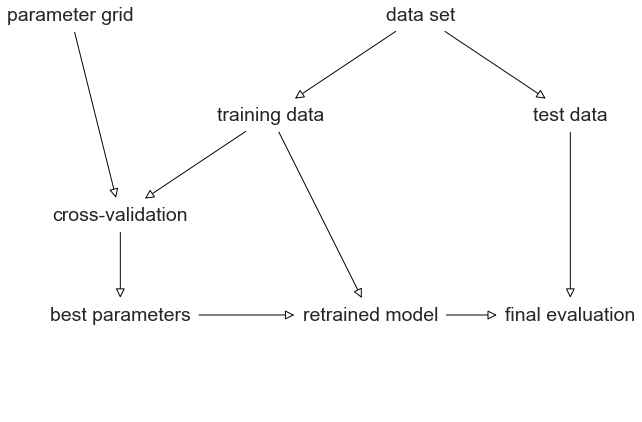

In [6]:
# データを分割し、グリッドサーチを行い、最後のパラメータを評価する過程
mglearn.plots.plot_grid_search_overview()

In [7]:
# grid_searchオブジェクトは通常のクラス分類器と同じように振る舞う。標準のfit, predict, scoreメソッドを呼ぶことができる
# 実際には、fitメソッドを呼ぶだけで、param_gridで指定したパラメータの組合せに対して交差検証が実行される
# 見つけたパラメータはbest_params_属性に、交差検証精度（そのパラメータ設定の様々な分割に対する平均精度）はbest_score_属性に格納されている
# scoreメソッドの結果（もしくはpredictメソッドの出力を評価した結果）は、訓練セット全体を用いて訓練したモデルを用いた結果である
# best_score_属性に格納されている値は、訓練セットに対する交差検証の平均交差検証精度だ
# 最良のパラメータを用いて訓練セット全体を用いて訓練したモデルには、best_estimator_属性を用いてアクセスすることができる
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C":[0.001,0.01,0.1,1,10,100],"gamma":[0.001,0.01,0.1,1,10,100]}
print(param_grid)
grid_search = GridSearchCV(SVC(), param_grid, cv = 5, refit = True)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
grid_search.fit(X_train, y_train)
print(f"Test set score: {grid_search.score(X_test, y_test):.2f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
print(f"Best estimator:\n{grid_search.best_estimator_}")

{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
Test set score: 0.97
Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97
Best estimator:
SVC(C=10, gamma=0.1)


<h4>交差検証の結果の解析</h4>

In [8]:
# グリッドサーチの結果はcv_results_属性に格納されている。これはディクショナリでサーチに関するさまざまな情報が格納されている
# 下に示すように大量で詳細な情報が格納されているので、pandasのDataFrameに変換してから見たほうがよい

results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001600,8.016855e-04,0.000797,3.986743e-04,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001605,4.940888e-04,0.000798,3.991406e-04,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001399,4.895901e-04,0.000599,4.894731e-04,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000995,8.283253e-06,0.000800,4.000459e-04,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000400,4.897456e-04,0.000200,3.998756e-04,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
5,0.000000,0.000000e+00,0.000000,0.000000e+00,0.001,100,"{'C': 0.001, 'gamma': 100}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
6,0.000000,0.000000e+00,0.000000,0.000000e+00,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
7,0.002469,3.962576e-03,0.000600,4.897851e-04,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
8,0.001199,3.996615e-04,0.000600,4.897457e-04,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
9,0.001198,4.111553e-04,0.000798,3.987970e-04,0.01,1,"{'C': 0.01, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


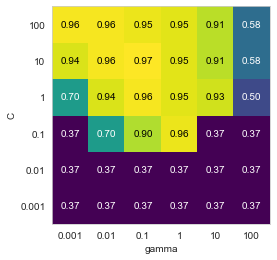

In [9]:
# 2次元（Cとgamma）のパラメータグリッドを探索しているのでヒートマップで可視化するのがよいだろう

scores = np.array(results.mean_test_score).reshape(6, 6)
mglearn.tools.heatmap(scores, xlabel = "gamma", xticklabels = param_grid["gamma"], ylabel = "C", yticklabels = param_grid["C"], cmap = "viridis")

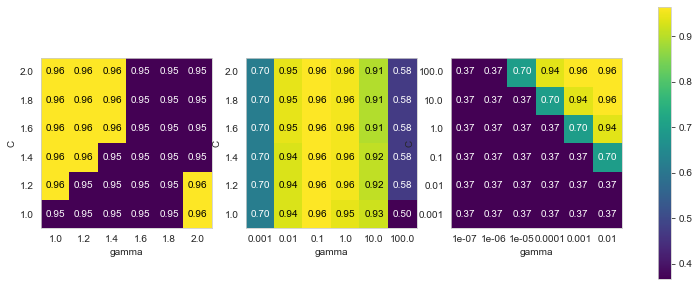

In [10]:
# パラメータのレンジは十分大きくしなければならないが、グリッドサーチは計算量的に高価なので、比較的粗く小さいグリッドから始めるほうがよい
# それぞれのパラメータの最良値がプロットの端にないようにするべきだ。下記は、サーチレンジが適切でなく、理想的でなくなったプロット例

fig, axes = plt.subplots(1, 3, figsize = (13, 5))

param_grid_linear = {"C":np.linspace(1,2,6),"gamma":np.linspace(1,2,6)}
param_grid_one_log = {"C":np.linspace(1,2,6),"gamma":np.logspace(-3,2,6)}
param_grid_range = {"C":np.logspace(-3,2,6),"gamma":np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_["mean_test_score"].reshape(6,6)
    
    scores_image = mglearn.tools.heatmap(scores, xlabel = "gamma", ylabel = "C", xticklabels = param_grid["gamma"], yticklabels = param_grid["C"], cmap = "viridis", ax = ax)

plt.colorbar(scores_image,ax = axes.tolist())

<h4>グリッドでないサーチ空間</h4>

In [11]:
# 「条件付き」パラメータを扱うために、GridSearchCVは、param_gridとしてディクショナリのリストを受け付けるように作られている
# リスト中の個々のディクショナリが独立したグリッドに展開される

param_grid = [{"kernel":["rbf"],"C":[0.001,0.01,0.1,1,10,100],"gamma":[0.001,0.01,0.1,1,10,100]},
              {"kernel":["linear"],"C":[0.001,0.01,0.1,1,10,100]}]
print(param_grid)
grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
results = pd.DataFrame(grid_search.cv_results_)
results.T

[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.002,0.001404,0.0014,0.001,0.0,0.003131,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.003124,0.0,0.0,0.003125,0.0,0.003124,0.0
std_fit_time,0.000632,0.000495,0.00049,0.000001,0.0,0.006261,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006249,0.0,0.0,0.006249,0.0,0.006249,0.0
mean_score_time,0.000999,0.000799,0.000799,0.0006,0.0,0.0,0.0,0.003124,0.0,0.0,...,0.0,0.003125,0.0,0.0,0.003124,0.0,0.0,0.0,0.0,0.0
std_score_time,0.000625,0.0004,0.0004,0.00049,0.0,0.0,0.0,0.006249,0.0,0.0,...,0.0,0.006249,0.0,0.0,0.006249,0.0,0.0,0.0,0.0,0.0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


<h4>異なる交差検証手法を用いたグリッドサーチ</h4>

In [12]:
# GridSearchCVは、cross_val_scoreと同様に、デフォルトではクラス分類には層化k分割交差検証を、回帰にはk分割交差検証を用いる
# 交差検証の分割器をcvパラメータとして渡すことができる
# 特に、訓練セットと検証セットへの分割を一度だけにするには、ShuffleSplitもしくはStratifiedShuffleSplitを用いてn_iter=1とするとよい

<h4>ネストした交差検証</h4>

In [13]:
# もとのデータを訓練セットとテストセットに一度だけ分けるのではなく、交差検証で何度も分割することを考える（ネストした交差検証）
# ネストした交差検証では、外側にループを設け、そこでデータを訓練セットとテストセットに分割する。それぞれの分割に対してグリッドサーチを実行する
# 外側ループのそれぞれの分割に対して最良のパラメータの組合せは異なるかもしれない
# ネストした交差検証は、未来のデータに適用するための予測モデルを探すために用いられることはほとんどない
# しかし、この手法は、あるモデルのあるデータセットに対する性能の評価には有用である

scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv = 5), iris.data, iris.target, cv = 5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


In [14]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    
    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = -np.inf
        
        for parameters in parameter_grid:
            cv_scores = []
            
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
        
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    
    return np.array(outer_scores)

In [15]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print(param_grid)
print(f"Cross-validation scores: {scores}") # なぜか結果がcross_val_score(GridSearchCV(SVC(),param_grid,cv),data,target,cv)と異なる
print("Mean cross-validation score: ", scores.mean())

[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score:  0.9800000000000001


<h4>交差検証とグリッドサーチの並列化</h4>

In [16]:
# GridSearchCVとcross_val_scoreでは、パラメータn_jobsに利用したいコア数を設定することで、複数のコアを利用することができる
# n_jobs = -1 を設定すると利用できるすべてのコアを利用する
# scikit-learnではネストした並列実行はサポートされていない
# したがってモデル（例えばランダムフォレスト）でn_jobsオプションを使っていたら、GridSearchCVでは使うことができない